**Unfallanalyse Köln (2019-2021) - Datenaufbereitung & Feature Engineering**

- Unfalldaten aus 3 Jahren zusammenführen
- POI-Distanzen berechnen (Bars, Schulen, Tankstellen)
- Zeitliche und räumliche Features ableiten
- Explorative Analyse

In [1]:
!pip install geopy tqdm -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy.spatial import cKDTree
from geopy.distance import geodesic
from tqdm.notebook import tqdm
tqdm.pandas()

### Daten laden
- 3 CSV-Dateien (2019-2021) zusammenführen
- Koordinaten und Zeitvariablen in numerische Formate umwandeln

In [2]:
dateien = [
   "Unfallstatistik 2019.csv",
   "Unfallstatistik 2020.csv",
   "Unfallstatistik 2021.csv"
]

dfs = []
for datei in dateien:
    df_temp = pd.read_csv(datei, sep=";", low_memory=False)
    dfs.append(df_temp)

df_unfaelle = pd.concat(dfs, ignore_index=True)
print(f"{len(df_unfaelle)} Unfälle aus {len(dateien)} Jahren geladen")

# Koordinaten: Komma durch Punkt, dann numerisch
for col in ['XGCSWGS84', 'YGCSWGS84']:
    df_unfaelle[col] = pd.to_numeric(
        df_unfaelle[col].astype(str).str.replace(',', '.'), errors='coerce'
    )

# Zeitvariablen numerisch
for col in ['USTUNDE', 'UMONAT', 'UWOCHENTAG']:
    df_unfaelle[col] = pd.to_numeric(df_unfaelle[col], errors='coerce')

# Koordinaten plausibel für Köln + Stunden plausibel
df_unfaelle = df_unfaelle[
    (df_unfaelle['XGCSWGS84'] < 7.16) &
    (df_unfaelle['YGCSWGS84'] > 50.825) &
    (df_unfaelle['USTUNDE'].between(0, 23))
]

print(f"Nach Filter: {len(df_unfaelle)} Unfälle")

12497 Unfälle aus 3 Jahren geladen
Nach Filter: 12488 Unfälle


### POI-Distanzen berechnen
- Bars/Pubs/Nightclubs, Schulen und Tankstellen via Overpass API laden
- Distanz zum nächsten POI per KDTree

In [3]:
def get_pois(category, retries=3):
    query = f"""
    [out:json];
    area["name"="Köln"]->.searchArea;
    node["amenity"="{category}"](area.searchArea);
    out body;
    """
    for attempt in range(retries):
        try:
            response = requests.get("http://overpass-api.de/api/interpreter", params={"data": query}, timeout=60)
            data = response.json()
            return [(e["lat"], e["lon"]) for e in data["elements"]]
        except:
            if attempt == retries - 1:
                return []

def get_bars_extended(retries=3):
    """Bars, Pubs, Nightclubs und Biergärten (nodes + ways)"""
    query = """
    [out:json][timeout:90];
    area(3600062578)->.searchArea;
    (
      node["amenity"="bar"](area.searchArea);
      way["amenity"="bar"](area.searchArea);
      node["amenity"="pub"](area.searchArea);
      way["amenity"="pub"](area.searchArea);
      node["amenity"="nightclub"](area.searchArea);
      way["amenity"="nightclub"](area.searchArea);
      node["amenity"="biergarten"](area.searchArea);
      way["amenity"="biergarten"](area.searchArea);
    );
    out center body;
    """
    for attempt in range(retries):
        try:
            response = requests.get("https://overpass-api.de/api/interpreter", params={"data": query}, timeout=90)
            data = response.json()
            coords = []
            for e in data["elements"]:
                if "lat" in e:
                    coords.append((e["lat"], e["lon"]))
                elif "center" in e:  # ways haben center statt lat/lon
                    coords.append((e["center"]["lat"], e["center"]["lon"]))
            return coords
        except:
            if attempt == retries - 1:
                return []

schools = get_pois("school")
bars = get_bars_extended()
fuel = get_pois("fuel")
print(f"Schulen: {len(schools)}, Bars: {len(bars)}, Tankstellen: {len(fuel)}")

Schulen: 56, Bars: 622, Tankstellen: 59


In [4]:
def build_kdtree(poi_list):
    coords = np.radians(np.array(poi_list))
    return cKDTree(coords), coords

def nearest_haversine(lat, lon, tree, coords):
    # Distanz in Metern zum nächsten POI
    radius = 6371000
    latlon = np.radians([lat, lon])
    dist, idx = tree.query(latlon, k=1)
    lat1, lon1 = latlon
    lat2, lon2 = coords[idx]
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return radius * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

tree_school, coords_school = build_kdtree(schools)
tree_bar, coords_bar = build_kdtree(bars)
tree_fuel, coords_fuel = build_kdtree(fuel)

df_unfaelle['dist_school'] = df_unfaelle.progress_apply(
    lambda row: nearest_haversine(row['YGCSWGS84'], row['XGCSWGS84'], tree_school, coords_school), axis=1)
df_unfaelle['dist_bar'] = df_unfaelle.progress_apply(
    lambda row: nearest_haversine(row['YGCSWGS84'], row['XGCSWGS84'], tree_bar, coords_bar), axis=1)
df_unfaelle['dist_fuel'] = df_unfaelle.progress_apply(
    lambda row: nearest_haversine(row['YGCSWGS84'], row['XGCSWGS84'], tree_fuel, coords_fuel), axis=1)

# Distanz zum Stadtzentrum (Kölner Dom)
cologne_center = (50.9413, 6.9583)
df_unfaelle['dist_center'] = df_unfaelle.apply(
    lambda row: geodesic((row['YGCSWGS84'], row['XGCSWGS84']), cologne_center).meters, axis=1)

print(f"Mittlere Distanz - Schule: {df_unfaelle['dist_school'].mean():.0f}m, Bar: {df_unfaelle['dist_bar'].mean():.0f}m, Tankstelle: {df_unfaelle['dist_fuel'].mean():.0f}m")

  0%|          | 0/12488 [00:00<?, ?it/s]

  0%|          | 0/12488 [00:00<?, ?it/s]

  0%|          | 0/12488 [00:00<?, ?it/s]

Mittlere Distanz - Schule: 1495m, Bar: 519m, Tankstelle: 1260m


### Feature Engineering
- Zeitfeatures: Wochentag, Monat, Jahreszeit, Tageszeit-Kategorien
- Unfallmerkmale: Schwere, Beteiligte
- Räumliche Features: Bar-Distanzzonen, Stadtzentrum

In [5]:
# Wochentag
weekday_map = {1: "Montag", 2: "Dienstag", 3: "Mittwoch", 4: "Donnerstag",
               5: "Freitag", 6: "Samstag", 7: "Sonntag"}
df_unfaelle["UWOCHENTAG_Name"] = df_unfaelle["UWOCHENTAG"].map(weekday_map).astype("category")

# Monat
month_map = {1:"Januar", 2:"Februar", 3:"März", 4:"April", 5:"Mai", 6:"Juni",
             7:"Juli", 8:"August", 9:"September", 10:"Oktober", 11:"November", 12:"Dezember"}
df_unfaelle["UMONAT_Name"] = df_unfaelle["UMONAT"].map(month_map).astype("category")

# Jahreszeit
df_unfaelle['Jahreszeit'] = df_unfaelle['UMONAT'].apply(
    lambda m: "Winter" if m in [12,1,2] else "Frühling" if m in [3,4,5] else
              "Sommer" if m in [6,7,8] else "Herbst"
).astype("category")

# Unfallschwere
category_map = {1: "Unfall mit Getöteten", 2: "Unfall mit Schwerverletzten", 3: "Unfall mit Leichtverletzten"}
df_unfaelle["UKATEGORIE"] = pd.to_numeric(df_unfaelle["UKATEGORIE"], errors="coerce")
df_unfaelle["UKATEGORIE_Name"] = df_unfaelle["UKATEGORIE"].map(category_map).astype("category")

# Tageszeit-Kategorien
df_unfaelle["ZeitKategorie"] = df_unfaelle["USTUNDE"].apply(
    lambda h: "Morgen" if 5 <= h < 11 else "Tag" if 11 <= h < 17 else
              "Abend" if 17 <= h < 21 else "Spätabend" if 21 <= h < 24 else "Nacht"
).astype("category")

# Wochenende
df_unfaelle['IstWochenende'] = df_unfaelle['UWOCHENTAG'].isin([6, 7]).astype(int)

# Nacht / Abend / Spätabend Flags
df_unfaelle["is_night"] = ((df_unfaelle["USTUNDE"] >= 23) | (df_unfaelle["USTUNDE"] <= 5)).astype(int)
df_unfaelle["is_evening"] = df_unfaelle["USTUNDE"].between(17, 21).astype(int)
df_unfaelle["is_late_evening"] = df_unfaelle["USTUNDE"].between(21, 23).astype(int)

# Zyklische Stunde (für Modelle die keine Kategorien können)
df_unfaelle["hour_sin"] = np.sin(2 * np.pi * df_unfaelle["USTUNDE"] / 24)
df_unfaelle["hour_cos"] = np.cos(2 * np.pi * df_unfaelle["USTUNDE"] / 24)

# Rush Hour und Arbeitszeit
df_unfaelle["RushHour"] = (df_unfaelle["USTUNDE"].between(7, 9) | df_unfaelle["USTUNDE"].between(16, 18)).astype(int)
df_unfaelle["Arbeitszeit"] = (df_unfaelle["USTUNDE"].between(7, 18) & (df_unfaelle["IstWochenende"] == 0)).astype(int)

print(f"Zeitfeatures erstellt, {len(df_unfaelle)} Zeilen")

Zeitfeatures erstellt, 12488 Zeilen


In [6]:
# Beteiligte
df_unfaelle['AnzahlBeteiligter'] = df_unfaelle[
    ['IstRad','IstPKW','IstFuss','IstKrad','IstGkfz','IstSonstige']
].sum(axis=1)
df_unfaelle['Motorisiert'] = (df_unfaelle[['IstPKW', 'IstKrad', 'IstGkfz']].sum(axis=1) >= 1).astype(int)

# Bar-Distanzzonen
df_unfaelle['dist_bar_zone'] = df_unfaelle['dist_bar'].apply(
    lambda m: "extrem_nah" if m < 50 else "sehr_nah" if m < 150 else
              "nah" if m < 300 else "mittel" if m < 600 else "weit"
).astype("category")

# Räumliche Scores
df_unfaelle['Distanzscore'] = df_unfaelle[['dist_school', 'dist_bar', 'dist_fuel', 'dist_center']].mean(axis=1)
df_unfaelle['Urban_Rural'] = (df_unfaelle['dist_center'] < 1000).astype(int)
df_unfaelle['Distanz_Minimum'] = df_unfaelle[['dist_school', 'dist_bar', 'dist_fuel']].min(axis=1)

# Interaktionen Bar x Tageszeit
df_unfaelle["bar_night_interaction"] = df_unfaelle["dist_bar"] * df_unfaelle["is_night"]
df_unfaelle["bar_evening_interaction"] = df_unfaelle["dist_bar"] * df_unfaelle["is_evening"]

# Straßenzustand
df_unfaelle["StrassenZustand"] = df_unfaelle.get("STRZUSTAND")
if "USTRZUSTAND" in df_unfaelle.columns:
    df_unfaelle["StrassenZustand"] = df_unfaelle["StrassenZustand"].fillna(df_unfaelle["USTRZUSTAND"])
df_unfaelle.drop(columns=["STRZUSTAND", "USTRZUSTAND"], inplace=True, errors="ignore")

zustand_map = {1: "trocken", 2: "feucht/nass", 3: "schnee/glätte", 4: "eis"}
df_unfaelle["StrassenZustand_Kat"] = df_unfaelle["StrassenZustand"].map(zustand_map).fillna("unbekannt").astype("category")

print(f"Alle Features erstellt: {df_unfaelle.shape[1]} Spalten")

Alle Features erstellt: 51 Spalten


### Bereinigen und speichern
- IDs und redundante Spalten raus

In [7]:
features_to_drop = [
    'OBJECTID', 'UIDENTSTLAE', 'LINREFX', 'LINREFY',
    'StrassenZustand', 'ULAND', 'UREGBEZ', 'UKREIS', 'UGEMEINDE'
]

df_unfaelle = df_unfaelle.drop(columns=features_to_drop, errors='ignore')

df_unfaelle.to_parquet("unfaelle_koeln_clean.parquet")
print(f"Gespeichert: {df_unfaelle.shape[0]} Zeilen, {df_unfaelle.shape[1]} Spalten")

Gespeichert: 12488 Zeilen, 42 Spalten


### Explorative Analyse

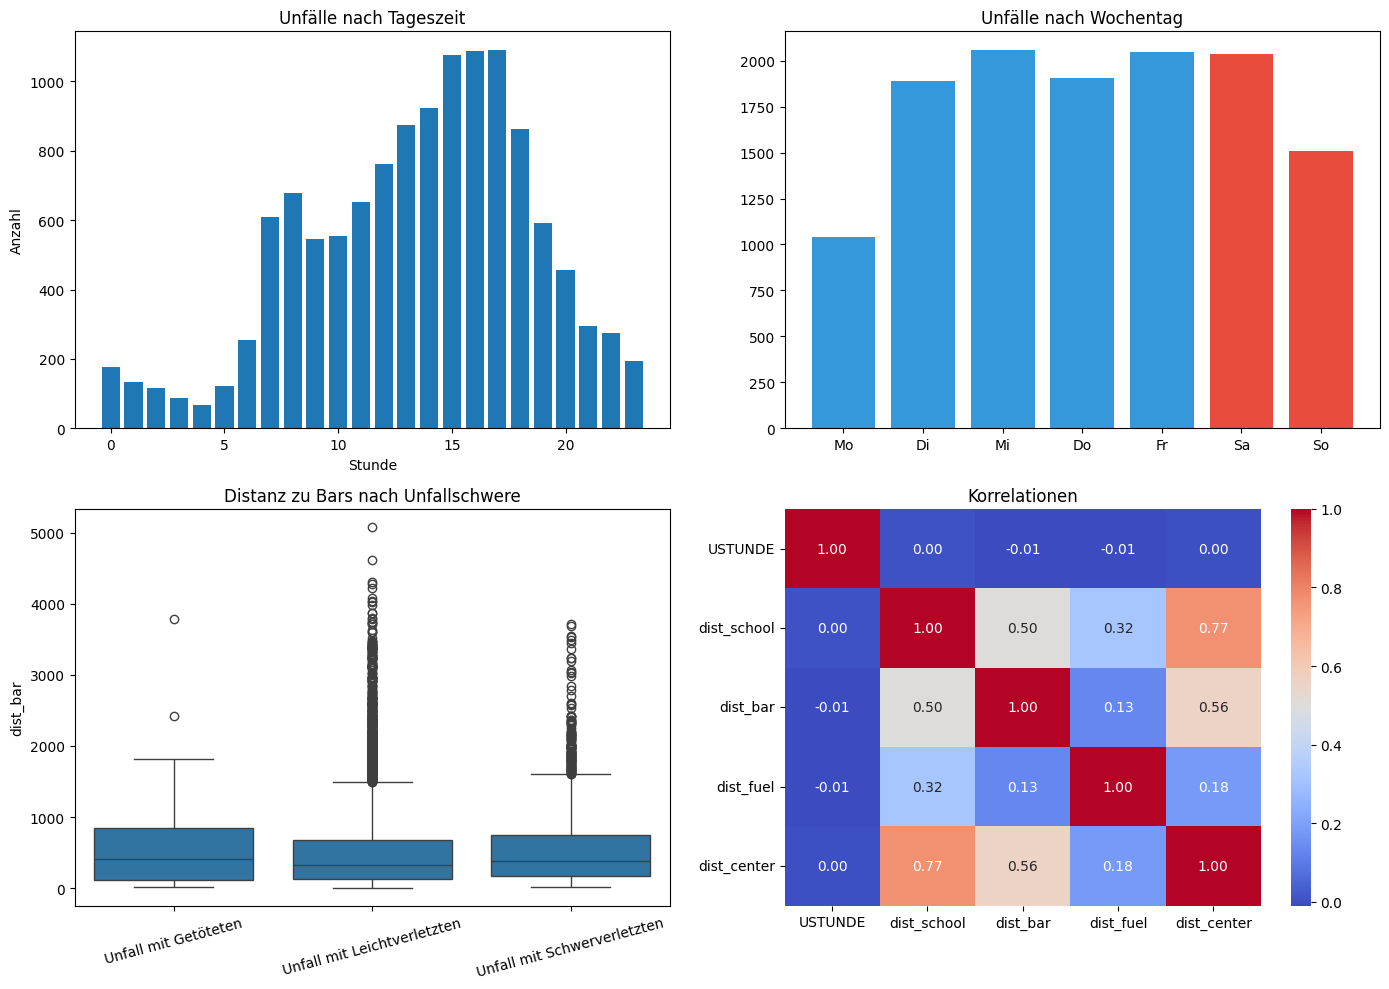

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Unfälle nach Stunde
axes[0,0].bar(range(24), df_unfaelle['USTUNDE'].value_counts().reindex(range(24), fill_value=0).values)
axes[0,0].set_xlabel('Stunde')
axes[0,0].set_ylabel('Anzahl')
axes[0,0].set_title('Unfälle nach Tageszeit')

# Unfälle nach Wochentag
order = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
day_counts = df_unfaelle['UWOCHENTAG_Name'].value_counts().reindex(order, fill_value=0)
axes[0,1].bar(range(7), day_counts.values, color=['#3498db']*5 + ['#e74c3c']*2)
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(['Mo','Di','Mi','Do','Fr','Sa','So'])
axes[0,1].set_title('Unfälle nach Wochentag')

# Distanz zu Bars nach Schwere
sns.boxplot(x='UKATEGORIE_Name', y='dist_bar', data=df_unfaelle, ax=axes[1,0])
axes[1,0].set_title('Distanz zu Bars nach Unfallschwere')
axes[1,0].set_xlabel('')
axes[1,0].tick_params(axis='x', rotation=15)

# Korrelation
num_cols = ['USTUNDE', 'dist_school', 'dist_bar', 'dist_fuel', 'dist_center']
corr = df_unfaelle[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1,1])
axes[1,1].set_title('Korrelationen')

plt.tight_layout()
plt.show()

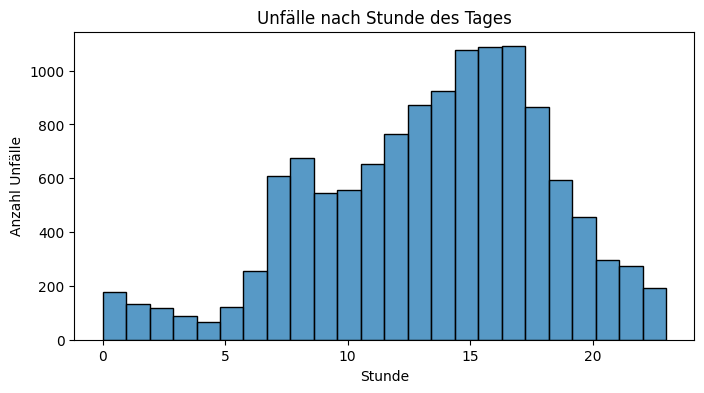

In [9]:
# Verteilung nach Tageszeit
plt.figure(figsize=(8,4))
sns.histplot(df_unfaelle['USTUNDE'], bins=24, kde=False)
plt.title("Unfälle nach Stunde des Tages")
plt.xlabel("Stunde")
plt.ylabel("Anzahl Unfälle")
plt.show()

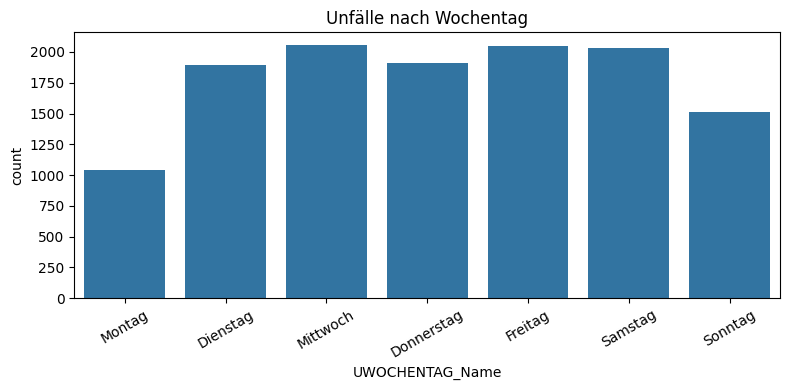

In [27]:
# Verteilung nach Wochentag
order = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]

plt.figure(figsize=(8, 4))
sns.countplot(
    x="UWOCHENTAG_Name",
    data=df_unfaelle.dropna(subset=["UWOCHENTAG_Name"]),
    order=order
)
plt.title("Unfälle nach Wochentag")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

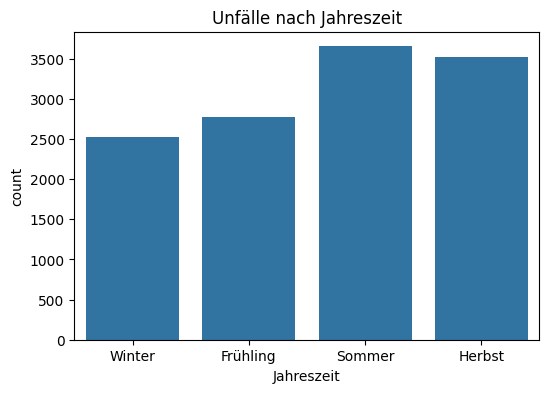

In [11]:
# Verteilung nach Jahreszeit
plt.figure(figsize=(6,4))
sns.countplot(x='Jahreszeit', data=df_unfaelle,
              order=['Winter','Frühling','Sommer','Herbst'])
plt.title("Unfälle nach Jahreszeit")
plt.show()

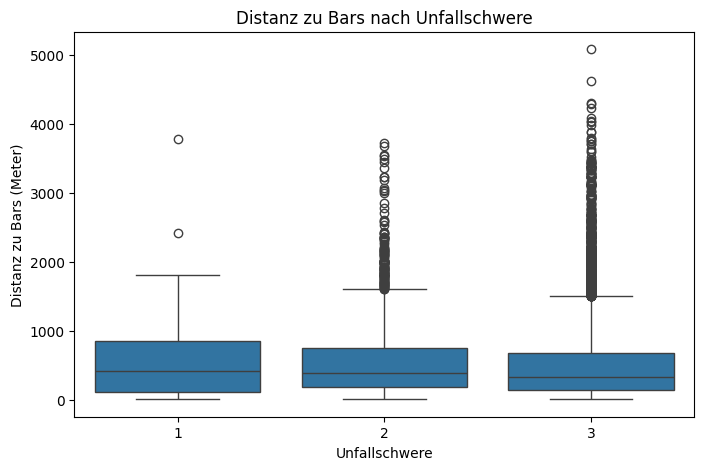

In [35]:
# Distanz zur nächsten Bar nach Unfallschwere
plt.figure(figsize=(8,5))
sns.boxplot(x='UKATEGORIE', y='dist_bar', data=df_unfaelle)
plt.title("Distanz zu Bars nach Unfallschwere")
plt.xlabel("Unfallschwere")
plt.ylabel("Distanz zu Bars (Meter)")
plt.show()

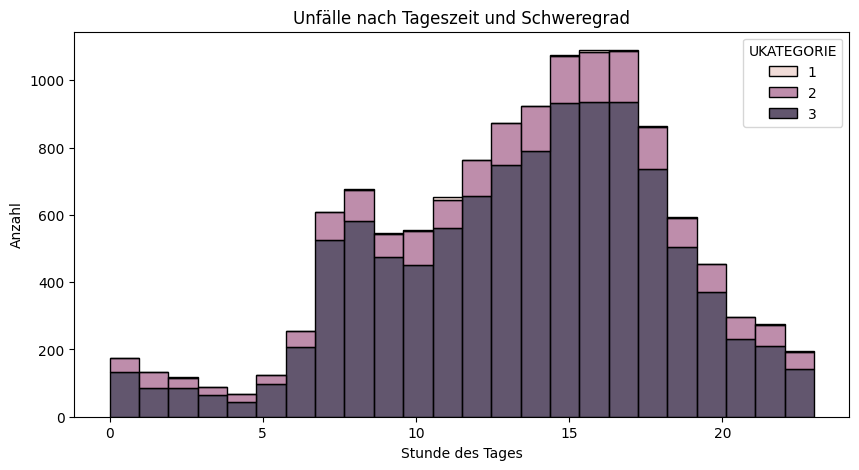

In [34]:
# Unfälle nach Tageszeit und Schweregrad
plt.figure(figsize=(10,5))
sns.histplot(data=df_unfaelle, x='USTUNDE', hue='UKATEGORIE', multiple='stack', bins=24)
plt.title("Unfälle nach Tageszeit und Schweregrad")
plt.xlabel("Stunde des Tages")
plt.ylabel("Anzahl")
plt.show()

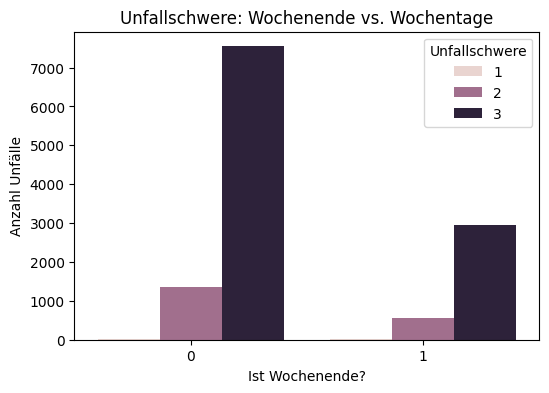

In [33]:
# Unfallschwere: Wochenende vs. Wochentage
plt.figure(figsize=(6,4))
sns.countplot(x='IstWochenende', hue='UKATEGORIE', data=df_unfaelle)
plt.title("Unfallschwere: Wochenende vs. Wochentage")
plt.xlabel("Ist Wochenende?")
plt.ylabel("Anzahl Unfälle")
plt.legend(title="Unfallschwere")
plt.show()

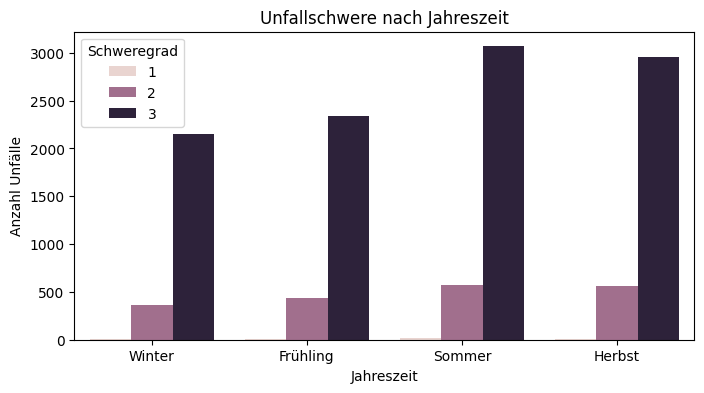

In [15]:
# Unfallschwere nach Jahreszeit
plt.figure(figsize=(8,4))
sns.countplot(x='Jahreszeit', hue='UKATEGORIE', data=df_unfaelle,
              order=['Winter', 'Frühling', 'Sommer', 'Herbst'])
plt.title("Unfallschwere nach Jahreszeit")
plt.xlabel("Jahreszeit")
plt.ylabel("Anzahl Unfälle")
plt.legend(title="Schweregrad")
plt.show()

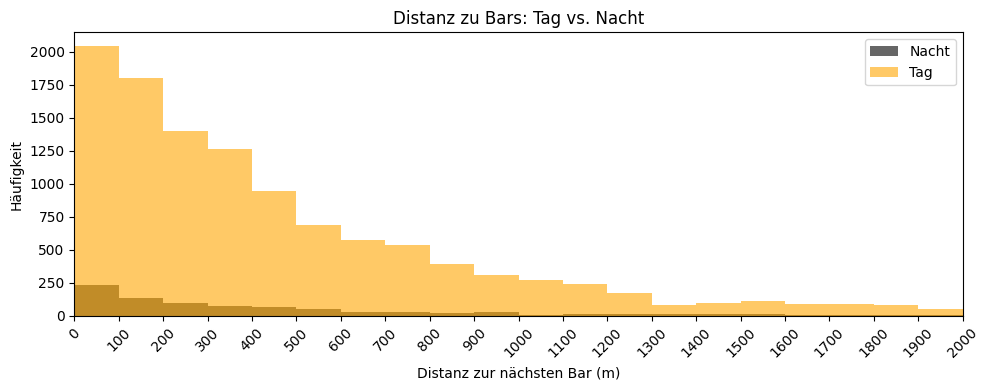

In [18]:
# Distanz zur nächsten Bar: Tag vs. Nacht
plt.figure(figsize=(10, 4))

bins = np.arange(0, 2100, 100)

plt.hist(
    unfaelle_df.loc[unfaelle_df["is_night"] == 1, "dist_bar"].dropna(),
    bins=bins,
    alpha=0.6,
    label="Nacht",
    color="#000000"
)

plt.hist(
    unfaelle_df.loc[unfaelle_df["is_night"] == 0, "dist_bar"].dropna(),
    bins=bins,
    alpha=0.6,
    label="Tag",
    color="#ffa600"
)

plt.xlabel("Distanz zur nächsten Bar (m)")
plt.ylabel("Häufigkeit")
plt.title("Distanz zu Bars: Tag vs. Nacht")
plt.legend()
plt.xticks(bins, rotation=45)
plt.xlim(0, 2000)

plt.tight_layout()
plt.show()

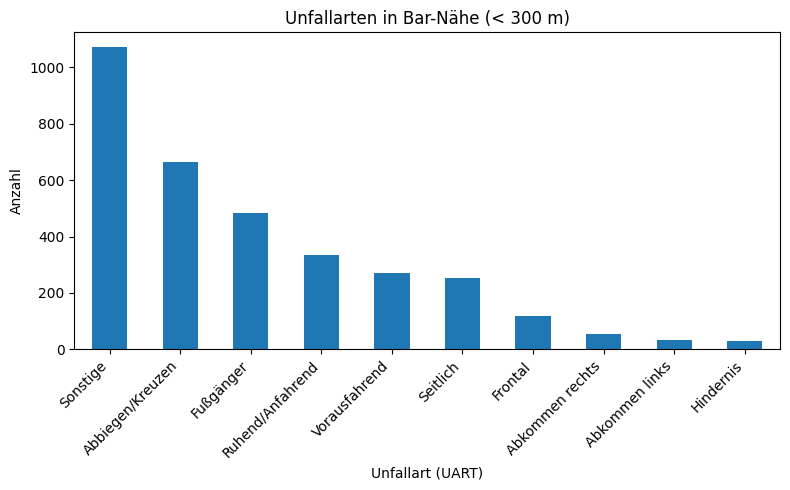

In [29]:
# Unfallarten in Bar-Nähe (<150 m)
near = unfaelle_df[unfaelle_df["dist_bar"] < 150].copy()

uart_labels_short = {
    0: "Sonstige",
    1: "Ruhend/Anfahrend",
    2: "Vorausfahrend",
    3: "Seitlich",
    4: "Frontal",
    5: "Abbiegen/Kreuzen",
    6: "Fußgänger",
    7: "Hindernis",
    8: "Abkommen rechts",
    9: "Abkommen links"
}

near["UART_text"] = near["UART"].map(uart_labels_short).fillna("Unbekannt")

plt.figure(figsize=(8, 5))
near["UART_text"].value_counts().plot(kind="bar")

plt.xlabel("Unfallart (UART)")
plt.ylabel("Anzahl")
plt.title(f"Unfallarten in Bar-Nähe (< {threshold} m)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

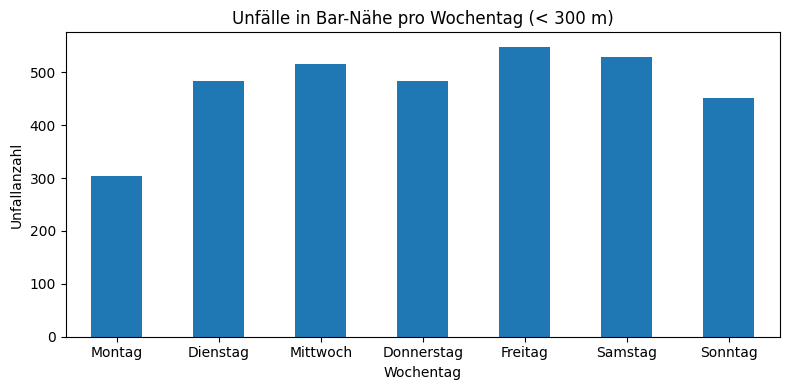

In [30]:
# Unfälle in Bar-Nähe pro Wochentag (<150 m)
near = unfaelle_df[unfaelle_df["dist_bar"] < 150].copy()

weekday_order = ["Montag", "Dienstag", "Mittwoch", "Donnerstag",
                 "Freitag", "Samstag", "Sonntag"]

if "UWOCHENTAG_Name" in near.columns:
    counts = near["UWOCHENTAG_Name"].value_counts().reindex(weekday_order).fillna(0)
else:
    weekday_num_order = [1, 2, 3, 4, 5, 6, 7]
    counts = near["UWOCHENTAG"].value_counts().reindex(weekday_num_order).fillna(0)
    counts.index = weekday_order

plt.figure(figsize=(8, 4))
counts.plot(kind="bar")

plt.xlabel("Wochentag")
plt.ylabel("Unfallanzahl")
plt.title(f"Unfälle in Bar-Nähe pro Wochentag (< {threshold} m)")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

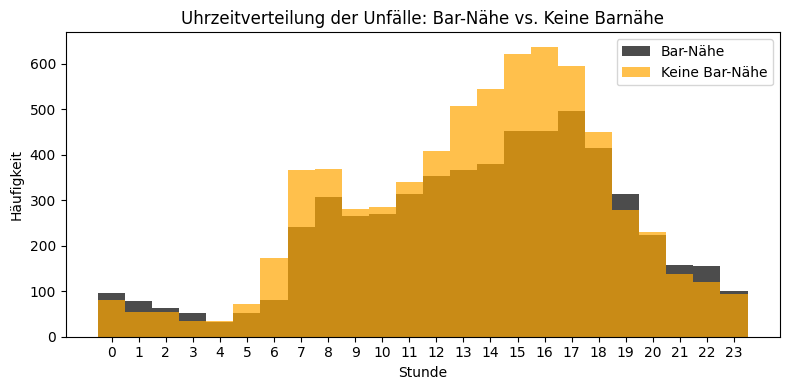

In [32]:
# Uhrzeitverteilung: Bar-Nähe (<300 m) vs. Keine Barnähe
near = unfaelle_df[unfaelle_df["dist_bar"] < 300]
far  = unfaelle_df[unfaelle_df["dist_bar"] >= 300]

plt.figure(figsize=(8, 4))

plt.hist(
    near["USTUNDE"].dropna(),
    bins=np.arange(-0.5, 24.5, 1),
    alpha=0.7,
    label="Bar-Nähe",
    color="#000000"
)

plt.hist(
    far["USTUNDE"].dropna(),
    bins=np.arange(-0.5, 24.5, 1),
    alpha=0.7,
    label="Keine Bar-Nähe",
    color="#ffa600"
)

plt.xlabel("Stunde")
plt.ylabel("Häufigkeit")
plt.title("Uhrzeitverteilung der Unfälle: Bar-Nähe vs. Keine Barnähe")
plt.xticks(range(0, 24))
plt.legend()

plt.tight_layout()
plt.show()